# PART I - Borders Vector Data

## Using Finland MML shapefiles for mapping

The Regions of Finland shapefile, retrieved from [opendata.fi](https://www.opendata.fi/data/en_GB/dataset/suomen-maakunnat-2021-vuoden-2018-maakuntakoodeilla), will be used to enrich our maps visualisation. It is provided by [The National Land Survey of Finland (MML)](https://www.maanmittauslaitos.fi/en/maps-and-spatial-data) and it is licensed under a Creative Commons Attribution 4.0 International License.

In [1]:
import pathlib
import geopandas as gpd

DATA_DIR = pathlib.Path().resolve() / "data"

# Load Finland MML regions without sea shapefile
regions_file = DATA_DIR / "regions" / "maakunnat2021_4500000_eimeri.shp"
finland_regions = gpd.read_file(regions_file)

# Retain only necessary columns and rename them to english
finland_regions = (
    finland_regions[["Maaku_ni1", "geometry"]]
    .rename(columns={"Maaku_ni1": "region_name"})
)

# List all regions of Finland
print(finland_regions["region_name"].unique())

['Uusimaa' 'Varsinais-Suomi' 'Satakunta' 'Kanta-Häme' 'Pirkanmaa'
 'Päijät-Häme' 'Kymenlaakso' 'Etelä-Karjala' 'Etelä-Savo' 'Pohjois-Savo'
 'Pohjois-Karjala' 'Keski-Suomi' 'Etelä-Pohjanmaa' 'Pohjanmaa'
 'Keski-Pohjanmaa' 'Pohjois-Pohjanmaa' 'Kainuu' 'Lappi'
 'Ahvenanmaan maakunta']


<Axes: >

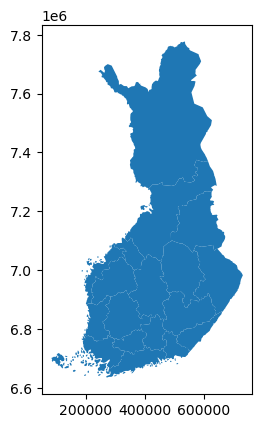

In [2]:
finland_regions.plot()

For a more in-depth analysis, the administrative borders could be used instead. The data is available at [Paituli](https://paituli.csc.fi/webservices.html) via WFS:

<Axes: >

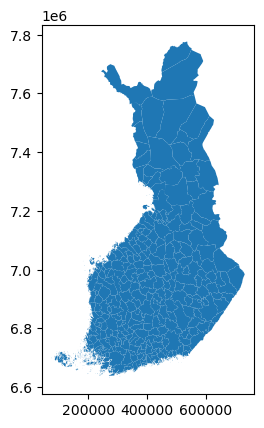

In [3]:
# Import Finalnd MML administrative borders without sea from Paituli via WFS
# dataset metadata: https://etsin.fairdata.fi/dataset/0a11579a-f420-4128-8e80-50b82d3905bd
borders = gpd.read_file(
        "https://paituli.csc.fi/geoserver/paituli/wfs"
        "?service=wfs"
        "&version=2.0.0"
        "&request=GetFeature"
        "&typeName=paituli:mml_hallinto_2025_milj_tk"
        "&srsName=EPSG:3067"
    ).set_crs("EPSG:3067")
borders.plot()

However, given the rasters we'll be using in this notebook only have a 10km resolution, the previous `finland_regions` shapefile will suffice for our analysis.

# Part II - `snow.py` module

## Using `snow` python module to read snow depth raster data from FMI

The dataset we will be using can be dowloaded from Paituli [here](https://paituli.csc.fi/download.html?data_id=il_daily_snow_10km_geotiff_euref). It contains daily snow depth by the Finnish Meteorological Institute (FMI) for the period 1961-2024.

A sample of the data has been provided in the repository to exemplify the usage. Code cells that require the full dataset will be marked as such.

The `open_snow_rasters` function provides a `missing_data` argument for loading the snow rasters when data is missing. For example, if you only want to load the sample rasters present in this repo:

In [4]:
import snow

# directory where snow rasters sample is stored
SNOW_DIR = DATA_DIR / "snow"

# dict of snow rasters by year
snow_rasters = snow.open_snow_rasters(SNOW_DIR, missing_data=True)

When using the sample data, only the following years are available:

In [5]:
snow_rasters.keys()

dict_keys([1961, 1981, 2001, 2021])

Now we proceed with the full dataset covering the period 1961-2022. (Since the data for 2023 is incomplete, the period 2023-24 is not analysed here.)

**Running this cell requires having downloaded the full dataset. Skip it if you're using only the sample data.** *(There are workarounds to run most of this notebook with sample data only)*

In [6]:
import snow
# directory where full dataset is present, change as needed
DATASET_DIRECTORY = pathlib.Path().resolve() / "ilmatiede" / "10km_daily_snow" / "geotiff"

# dict of snow rasters 1961-2022 by year
snow_rasters = snow.open_snow_rasters(DATASET_DIRECTORY)

In each yearly raster, there is one band for each day of the year, whith each band containing 68*116 pixels of snow depth cover (in cm). 

For example, for 1981 we have the following raster: 

In [7]:
print(snow_rasters[1981])

<xarray.DataArray (band: 365, y: 116, x: 68)> Size: 12MB
[2879120 values with dtype=float32]
Coordinates:
  * band         (band) int64 3kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
  * x            (x) float64 544B 6.869e+04 7.869e+04 ... 7.287e+05 7.387e+05
  * y            (y) float64 928B 7.782e+06 7.772e+06 ... 6.642e+06 6.632e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  84.834418515138
    STATISTICS_MEAN:     nan
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   nan
    scale_factor:        1.0
    add_offset:          0.0


## Analyzing Finnish christmas data with `snow` module

Besides loading the data, the `snow` module provides several functions for analyzing the rasters, focusing in particular in the Christmas season snow depth and the ocurrence of "White Christmas".

The function `avg_xmas_snow_rasters` converts the previously obtained snow rasters into a new dictionary with the Christmas average snow depth for each year. Each year's Christmas average is obtained by averaging the snow depth rasters of 24, 25 and 26 of December.

In [8]:
# dict of Christmas avg snow for each year in snow_rasters data
xmas_avg_snow = snow.avg_xmas_snow_rasters(snow_rasters)

A plot of a single year Christmas average snow depth looks like the following:

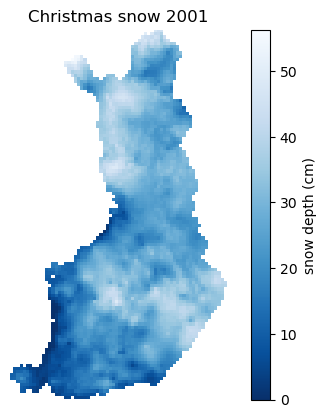

In [9]:
import matplotlib.pyplot as plt

# Choose year for analysis
year = 2001 # Change to your desired year within [1961-2022]

# Plot xmas average snow depth (24.-26.12) for chosen year
plt.imshow(xmas_avg_snow[year], cmap="Blues_r")
plt.colorbar(label="snow depth (cm)")
plt.axis("off")
plt.title(f"Christmas snow {year}")
plt.show()

Using the previously calculated Christmas average snow data, we can now classify each christmas into white if the snow depth is over a certain threshold. The module also provides custom plot functions for better visualising this (and other) classifications. (Note: all plot functions in `snow.py` have an optional `borders` argument for including a polygon layer such as our `finland_regions`)

The function `classify_white_day` classifies raster values into 2 classes: `0` for No snow and `1` for White day.

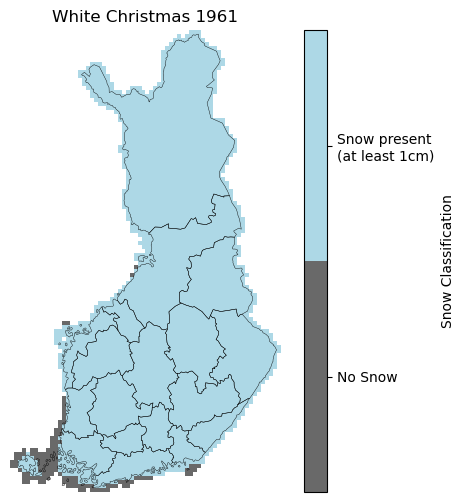

In [10]:
# Choose year for analysis
year = 1961

# Obtain White Christmas classification using average snow depth for 24.-26.12 of chosen year
white_xmas_raster = snow.classify_white_day(xmas_avg_snow[year])

# Custom function for plotting White Christmas map
snow.plot_white_xmas(white_xmas_raster, year, borders=finland_regions)

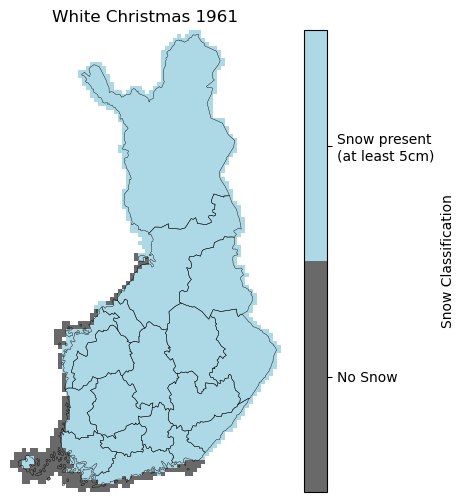

In [11]:
# NOTE: By default, the snow classifiers in this project use 1cm snow depth as the threshold for "white" classification
# We can classify (and plot!) with different thresholds the following way:
white_xmas_raster = snow.classify_white_day(xmas_avg_snow[year], snow_threshold=5) # 5cm snow threshold
snow.plot_white_xmas(white_xmas_raster, year, snow_threshold=5, borders=finland_regions)

# Part III - Results

## Probability of a White Christmas in Finland 
Now, we proceed to analyse the probability of having a white Christmas based on the 30 year period 1991-2020, inspired by [this FMI analysis](https://www.ilmatieteenlaitos.fi/joulunaika):

![FMI white christmas map](https://www.ilmatieteenlaitos.fi/hli0qi7fbbos/6puwhIPvW257KUoo9DDWoh/d6c1a0065cb5cde4b6ceb2d2e3989d29/joulu_valkea_9120.png)

In this FMI map there are 5 different categories describing the likelihood of a White Christmas (24.-26.12) across Finland, from only 1 in 2 christmas being white all the way to always white. 

Using the white christmas classifications we obtained so far, we'll proceed to create similar maps. For this purpose we'll explore further "White Christmas" classification functions available in our `snow` module.

The `white_avg_xmas_sum` function leverages the binary 0-1 "White day" classification we used previously to sum the occurrences of white christmas over a given period, obtaining an effective count of the phenomena:

In [12]:
import rioxarray as rxr

# raster file for sample data compability
raster_file = SNOW_DIR / "wh_xmas_sum_1991_2020.tif"

# Define period for "White Christmas" likelihood analysis
start_year = 1991
end_year = 2020

try:
    # Raster with nr. of occurrences of "White Christmas" over chosen period
    wh_xmas_sum_1991_2020 = snow.white_avg_xmas_sum(xmas_avg_snow, start_year, end_year)

    # Optional: save raster for future use
    # wh_xmas_sum_1991_2020.rio.to_raster(raster_file) # DON'T RUN WITH SAMPLE DATA, IT WILL OVERWRITE EXISTING RASTER

# When using only the sample data, xmas_avg_snow will be incomplete
except KeyError:
    #  Load previous analysis from full dataset instead
    wh_xmas_sum_1991_2020 = rxr.open_rasterio(raster_file).sel(band=1)

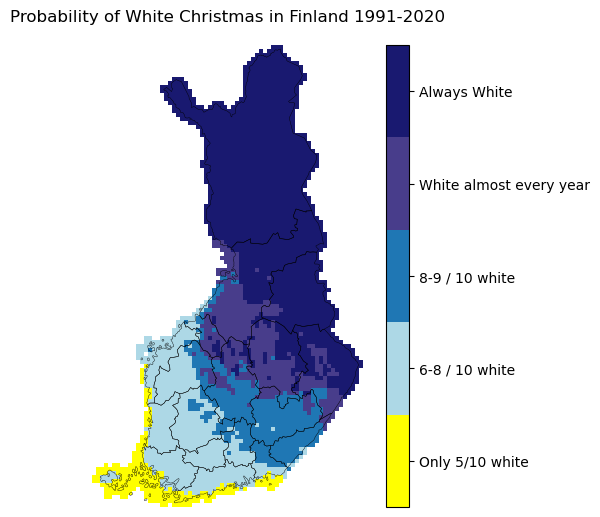

In [13]:
# Our period covers 30 years but the classification requires a 10-year scale
wh_xmas_sum_1991_2020 /= 3

# Classify probability of "White Christmas" occurring every 10 years into 5 classes
prob_wxmas_1991_2020 = snow.classify_prob_white_xmas(wh_xmas_sum_1991_2020)

# Custom plot of "White Christmas" probability classes
snow.plot_prob_white_xmas(prob_wxmas_1991_2020, start_year, end_year, finland_regions)

The previous classification used the criteria of "average christmas snow depth" by classifying a christmas as white if the 24.-26.12 average was over the threshold (1cm). 

Alternatively, `all3_white_xmas_sum` classifies a christmas as white with a stricter criteria: if all 3 christmas days are "white days". Here's an example of this classification for the same 1991-2020 period:

**Running this cell requires having downloaded the full dataset. Skip it if you're using only the sample data.**

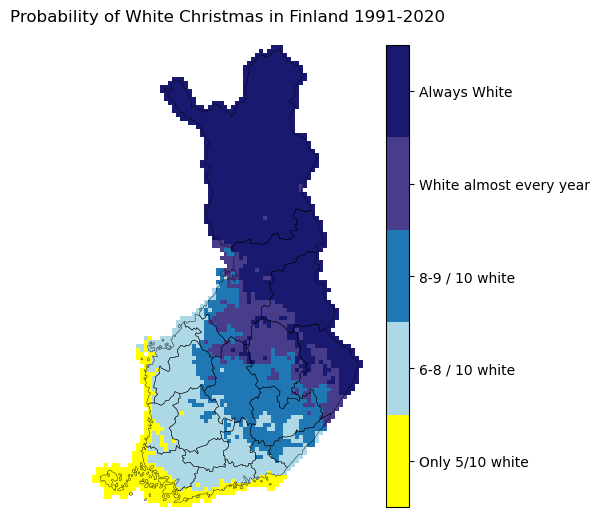

In [14]:
# Raster with nr. of occurrences of "White Christmas" using all3 criteria
all3_white_xmas_sum = snow.all3_white_xmas_sum(snow_rasters) # year interval defaults to 1991-2020

# change 30-year scale to 10-year scale
all3_white_xmas_sum /= 3

# Classify probability of "White Christmas" and plot same as before
all3_white_prob = snow.classify_prob_white_xmas(all3_white_xmas_sum)
snow.plot_prob_white_xmas(all3_white_prob, start_year, end_year, finland_regions)


Considering the FMI original map, the 24.-26.12 average classification seems to be the most similar. We'll continue using it.

Finally, let's observe the change in White Christmas probability over 2 consecutive 30-year periods:

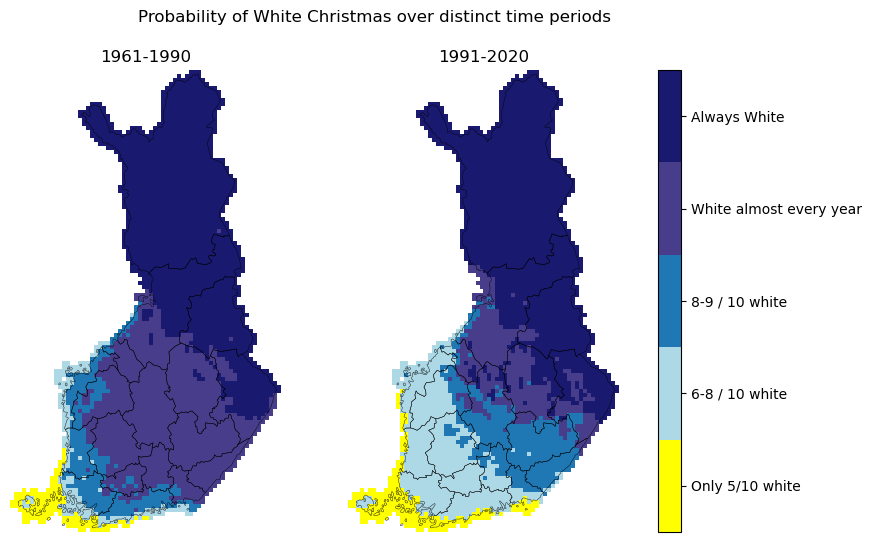

In [15]:
# Define analysis period as 1961-1990
start_year = 1961
end_year = 1990

# raster file for sample data compability
raster_file = SNOW_DIR / "wh_xmas_sum_1961_1990.tif"

try:
    wh_xmas_sum_1961_1990 = snow.white_avg_xmas_sum(xmas_avg_snow, start_year, end_year)

    # Optional: save raster for future use
    # wh_xmas_sum_1961_1990.rio.to_raster(raster_file) # DON'T RUN WITH SAMPLE DATA, IT WILL OVERWRITE EXISTING RASTER

# When using only the sample data, xmas_avg_snow will be incomplete
except KeyError:
    #  Load previous analysis from full dataset instead
    wh_xmas_sum_1961_1990 = rxr.open_rasterio(raster_file).sel(band=1)


# change 30-year scale to 10-year scale
wh_xmas_sum_1961_1990 /= 3

# classify "White Christmas" probability for 1961-1990
prob_wxmas_1961_1990 = snow.classify_prob_white_xmas(wh_xmas_sum_1961_1990)


snow.plot_prob_wxmas_side_by_side(prob_wxmas_1961_1990, 1961, 1990, prob_wxmas_1991_2020, 1991, 2020, finland_regions)

The plot shows that the probabilities of having a White Christmas have changed considerably in a period of just 60 years. While the region of Lapland maintains its constant christmas snow, the south of the country has changed significantly, with 6-8/10 white christmas now being the norm in most of the south and western regions.

# Part IV - Extra

### Analysis of speficic regions with user-defined criteria
Besides the previously shown analysis, the `snow.py` functions also allow for a more in-depth exploration of specific areas. Depending on the vector data available, one can zoom-in to observe more specific data or patterns of interest concerning a single region. 

Let us now return to our initial `finland_borders` vector data, and consider the region of Pirkanmaa, where the city of Tampere is located:

In [16]:
pirkanmaa = finland_regions[finland_regions["region_name"] == "Pirkanmaa"]

We can now take advantage of OSM's background maps to better visualise where the data is. Using `classify_all_white_xmas`, the following example looks at where all 3 Christmas days of 1961 always had at least 10cm of snow:

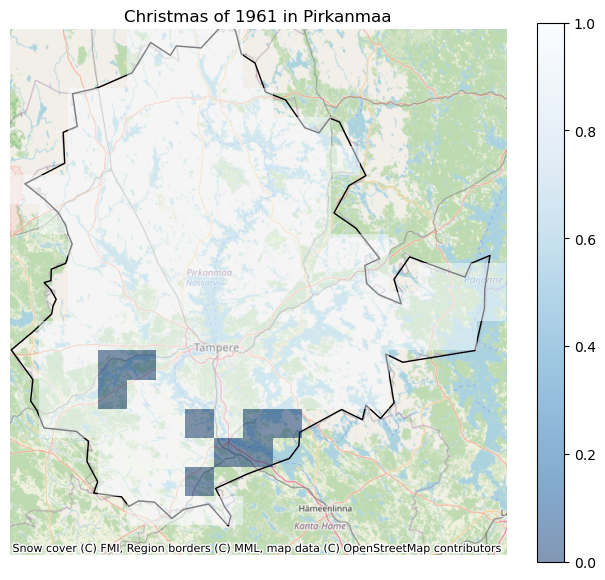

In [17]:
import contextily

# Map tiles from online map providers are typically in Web Mercator projection (EPSG:3857)
# transform all layers to match
pirkanmaa = pirkanmaa.to_crs("EPSG:3857")

ax = pirkanmaa.plot(
    figsize=(8, 7),
    facecolor='none',
    linewidth=1
)

# Classify xmas of 61 as all white if all 3 days had at least 10cm of snow depth
raster = snow.classify_all_white_xmas(snow_rasters[1961], snow_threshold=10)

# Clip classification to region of Pirkanmaa
raster = raster.rio.clip(pirkanmaa.geometry.values, pirkanmaa.crs)

# Reproject to required web mercator projection
raster = raster.rio.reproject(dst_crs="EPSG:3857")

raster.plot(ax=ax, cmap="Blues_r", alpha=0.5)
ax.set_title("Christmas of 1961 in Pirkanmaa")

# add background map from OSM
contextily.add_basemap(
    ax=ax,
    source=contextily.providers.OpenStreetMap.Mapnik,
    attribution=(
        "Snow cover (C) FMI, "
        "Region borders (C) MML, "
        "map data (C) OpenStreetMap contributors"
    )
)
plt.axis('off')
plt.show()

According to the binary 0-1 (Not white - White) classification, the plot shows us in dark blue the few locations in Pirkanmaa where the christmas was not "white" according to our previously defined criteria.

### White Christmas probability change in a single region
Finally, we can also use the previously seen `plot_prob_wxmas_side_by_side` function to look at our past time period probability changes exclusively in the region of Pirkanmaa:

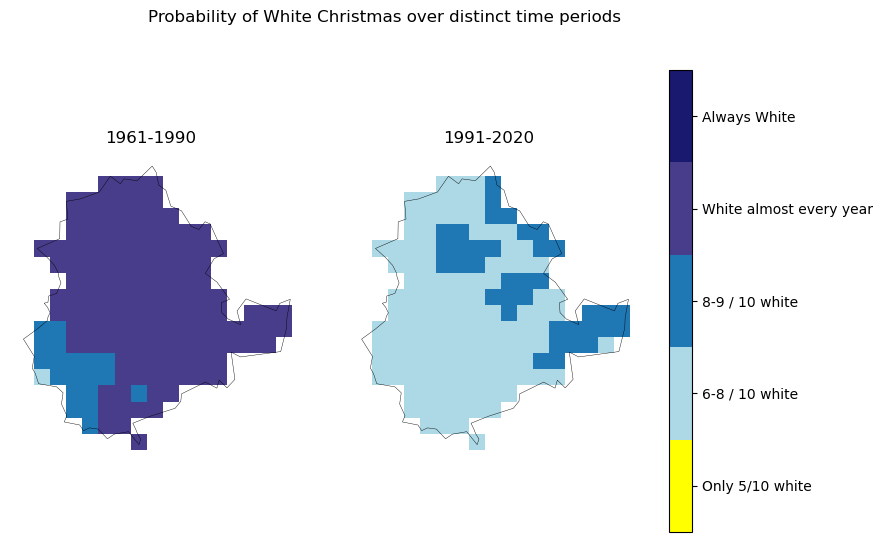

In [18]:
raster1 = prob_wxmas_1961_1990.rio.clip(pirkanmaa.geometry.values, pirkanmaa.crs)
raster2 = prob_wxmas_1991_2020.rio.clip(pirkanmaa.geometry.values, pirkanmaa.crs)


snow.plot_prob_wxmas_side_by_side(raster1, 1961, 1990, raster2, 1991, 2020, pirkanmaa)